# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
# from  import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

2024-02-19 19:48:19.470010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 19:48:19.470046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 19:48:19.471050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 19:48:19.477664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 19:48:20.552214: W tensorflow/compiler/tf2

4422102/4422102 [==============================] - 1s 0us/step


In [2]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [16]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
import time

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.sigma_squared = None
        self.pca = None
        self.w = None
        self.u = None
        self.scaler = None

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.scaler = Normalizer().fit(X)
        X = self.scaler.transform(X)
        
        # понижаем размерность если нужно
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)


        # считаем сигму в матричном виде
        ind = np.random.choice(X.shape[0], size=(2, 1000))
        ind = ind[:, ind[0] != ind[1]]
        self.sigma_squared = np.median(np.sum((X[ind[0]] - X[ind[1]]) ** 2, axis=1))

        # генерим u, w и новые признаки
        self.w = np.random.normal(0, 1 / np.sqrt(self.sigma_squared), size=(X.shape[1], self.n_features))
        self.u = np.random.uniform(-np.pi, np.pi, self.n_features)

        non_linear_X = np.cos(X @ self.w + self.u)

        # учим модель
        if self.classifier == "svm":
            self.model = SVC(kernel="linear").fit(non_linear_X, y)
        elif self.classifier == "logreg":
            self.model = LogisticRegression(max_iter=3000).fit(non_linear_X, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.scaler.transform(X)

        if self.use_PCA:
            X = self.pca.transform(X)

        non_linear_X = np.cos(X @ self.w + self.u)

        return self.model.predict_proba(non_linear_X)

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.scaler.transform(X)

        if self.use_PCA:
            X = self.pca.transform(X)

        non_linear_X = np.cos(X @ self.w + self.u)

        return self.model.predict(non_linear_X)

In [5]:
rffpip = RFFPipeline()
rffpip.fit(x_train, y_train)
y_pred = rffpip.predict(x_test)

print(f'accuracy = {np.mean(y_pred == y_test)}')

/home/boris/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 0.882


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [19]:
def print_stats(model, X, y):
    y_pred = model.predict(X)
    print(f'accuracy = {accuracy_score(y, y_pred)}')
    print(f'precision = {precision_score(y, y_pred, average="macro")}')
    print(f'recall = {recall_score(y, y_pred, average="macro")}')

In [14]:
# считается что-то реально очень долго, поэтому пришлось взять так мало объектов
ind = np.random.choice(len(x_train), size=6000, replace=False)

**Наша модель**

In [20]:
# с логрегом
start = time.time()
model = RFFPipeline(classifier="logreg").fit(x_train[ind], y_train[ind])
print("Time: {:.3f}s".format(time.time() - start))

print_stats(model, x_test, y_test)

/home/boris/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time: 211.211s
accuracy = 0.8462
precision = 0.8457432414917756
recall = 0.8462


In [22]:
# с svm
start = time.time()
model = RFFPipeline(classifier="svm").fit(x_train[ind], y_train[ind])
print("Time: {:.3f}s".format(time.time() - start))

print_stats(model, x_test, y_test)

Time: 6.730s
accuracy = 0.8391
precision = 0.8389710067292977
recall = 0.8390999999999998


**LinearSVM**


In [23]:
start = time.time()
model = LinearSVC().fit(x_train[ind], y_train[ind])
print("Time: {:.3f}s".format(time.time() - start))

print_stats(model, x_test, y_test)

/home/boris/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Time: 11.178s
accuracy = 0.7539
precision = 0.760919310897707
recall = 0.7539


/home/boris/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**KernelSVM sklearn**

In [24]:
start = time.time()
model = SVC(kernel="rbf").fit(x_train[ind], y_train[ind])
print("Time: {:.3f}s".format(time.time() - start))

print_stats(model, x_test, y_test)

Time: 4.911s
accuracy = 0.8346
precision = 0.8325724835059753
recall = 0.8346


**CatBoost**

In [25]:
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import train_test_split

In [28]:
def objective(trial):
    params = {
        "num_trees": trial.suggest_int("num_trees", 2, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0, 1)
    }
    
    classifier = CatBoostClassifier(**params, verbose=False).fit(train_features, train_labels)
    predictions = classifier.predict(validation_features).reshape(1, -1)[0]
    accuracy = accuracy_score(validation_labels, predictions)
    precision = precision_score(validation_labels, predictions, average='macro')
    recall = recall_score(validation_labels, predictions, average='macro')
    return accuracy, precision, recall


pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(x_train)
test_features_pca = pca.transform(x_test)

train_features, validation_features, train_labels, validation_labels = train_test_split(train_features_pca, y_train, train_size=0.7, random_state=42)
study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=20)

[I 2024-02-19 21:02:20,389] A new study created in memory with name: no-name-35c22da1-6020-4646-99e2-7d3fa195c336
[I 2024-02-19 21:02:29,298] Trial 0 finished with values: [0.8427222222222223, 0.8408116370949366, 0.8426932087919591] and parameters: {'num_trees': 50, 'learning_rate': 0.3967773047361719}. 
[I 2024-02-19 21:02:45,826] Trial 1 finished with values: [0.8472777777777778, 0.8457297899913151, 0.847217830502992] and parameters: {'num_trees': 95, 'learning_rate': 0.742573051416155}. 
[I 2024-02-19 21:02:48,590] Trial 2 finished with values: [0.7188888888888889, 0.7113169373982722, 0.7190768920261376] and parameters: {'num_trees': 8, 'learning_rate': 0.15275356021597253}. 
[I 2024-02-19 21:03:08,841] Trial 3 finished with values: [0.8609444444444444, 0.8595826667587494, 0.8609088670100256] and parameters: {'num_trees': 138, 'learning_rate': 0.3153630581916711}. 
[I 2024-02-19 21:03:10,165] Trial 4 finished with values: [0.6962777777777778, 0.6926182662926956, 0.6963168840069431] 

In [42]:
best = study.best_trials
print('Stats of the best run: ')
print(f'accuracy = {best[0].values[0]}')
print(f'precision = {best[0].values[1]}')
print(f'recall = {best[0].values[2]}')

print("Params: ")
for key, value in best[0].params.items():
    print("{}: {}".format(key, value))

Stats of the best run: 
accuracy = 0.8662222222222222
precision = 0.8649215778526871
recall = 0.866177058481316
Params: 
num_trees: 188
learning_rate: 0.2600113101639304


In [45]:
start = time.time()
model = CatBoostClassifier(num_trees=188, learning_rate=0.26, verbose=False).fit(train_features_pca[ind], y_train[ind])
print("time: {:.3f}s".format(time.time() - start))

y_pred = model.predict(test_features_pca).reshape(1, -1)[0]
print(f'accuracy = {accuracy_score(y_test, y_pred)}')
print(f'precision = {precision_score(y_test, y_pred, average="macro")}')
print(f'recall = {recall_score(y_test, y_pred, average="macro")}')

time: 11.292s
accuracy = 0.8256
precision = 0.8239116989782929
recall = 0.8256


**Вывод:**

Нетрудно заметить, что наша модель, использующая случайные признаки показывает наилучшее качество, ядровой svm сравним с ним. Линейный SVM совсем плохо справляется с большим количеством данных.

CatBoost показал качество сравнимое с RFF и ядровым svm, но зато был быстрее, чем они. Идея со случайными признаками хороша, потому что она и правда позволяет улучшить качество, тем не менее такой подход работает оооочень долго. Мне кажется именно из-за этого бустинг гораздо больше распрастранен в приложениях, нежели ядровые методы, даже аппроксимируемые дискретным количеством признаков.



__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

#### Помогает ли предварительное понижение размерности с помощью PCA? 

In [51]:
import pandas as pd

In [47]:
def get_stats(model, X, y):
    y_pred = model.predict(X)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, average='macro'),
        "recall": recall_score(y, y_pred, average='macro')
    } 

In [ ]:
new_dims = [20, 50, 100, 200, 500]
results = []
    
rff = RFFPipeline(use_PCA=False, classifier="logreg").fit(x_train[ind], y_train[ind])
tmp_results = get_stats(rff, x_test, y_test)

tmp_results['num_dims'] = x_train.shape[1]
results.append(tmp_results)
for new_dim in new_dims:
    new_dim = int(new_dim)
    rff = RFFPipeline(new_dim=new_dim, classifier="logreg").fit(x_train[ind], y_train[ind])
    tmp_results = get_stats(rff, x_test, y_test)
    tmp_results['num_dims'] = new_dim
    results.append(tmp_results)

In [56]:
res = pd.DataFrame(results).sort_values(by='num_dims')
res

,accuracy,precision,recall,num_dims
1,0.8379,0.837452,0.8379,20
2,0.8520,0.851811,0.8520,50
3,0.8413,0.841900,0.8413,100
4,0.8425,0.842702,0.8425,200
5,0.8317,0.832961,0.8317,500
0,0.8339,0.834661,0.8339,784


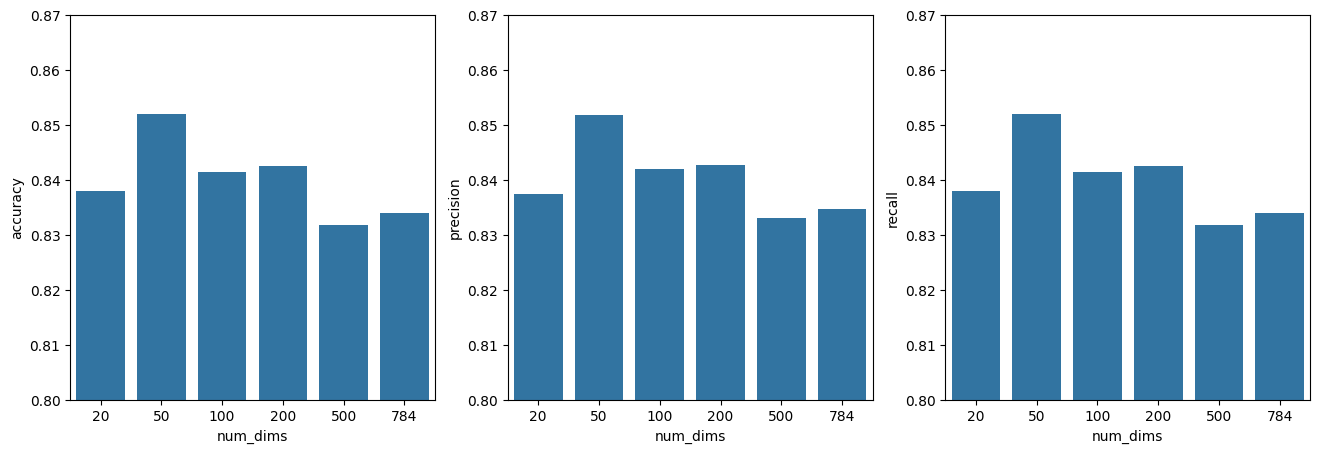

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
ax = sns.barplot(data=res, x='num_dims', y="accuracy")
ax.set(ylim=(0.8, 0.87))

plt.subplot(1, 3, 2)
ax = sns.barplot(data=res, x='num_dims', y="precision")
ax.set(ylim=(0.8, 0.87))

plt.subplot(1, 3, 3)
ax = sns.barplot(data=res, x='num_dims', y="recall")
ax.set(ylim=(0.8, 0.87))

plt.show()

**Вывод:** Видно, что по каждой метрике наблюдается пик в районе num_dims = 50, значит количество размерностей равное 50 является оптимальным.

#### Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?

In [ ]:
n_featureses = np.arange(500, 5000, 1000)
results = []

for n_features in n_featureses:
    rff = RFFPipeline(n_features=n_features, classifier="logreg").fit(x_train[ind], y_train[ind])
    tmp_results = get_stats(rff, x_test, y_test)
    tmp_results['n_features'] = n_features
    results.append(tmp_results)

res = pd.DataFrame(results)

In [73]:
res

,accuracy,precision,recall,n_features
0,0.8446,0.844415,0.8446,500
1,0.8481,0.847969,0.8481,1500
2,0.8471,0.846981,0.8471,2500
3,0.8480,0.848151,0.8480,3500
4,0.8443,0.844500,0.8443,4500


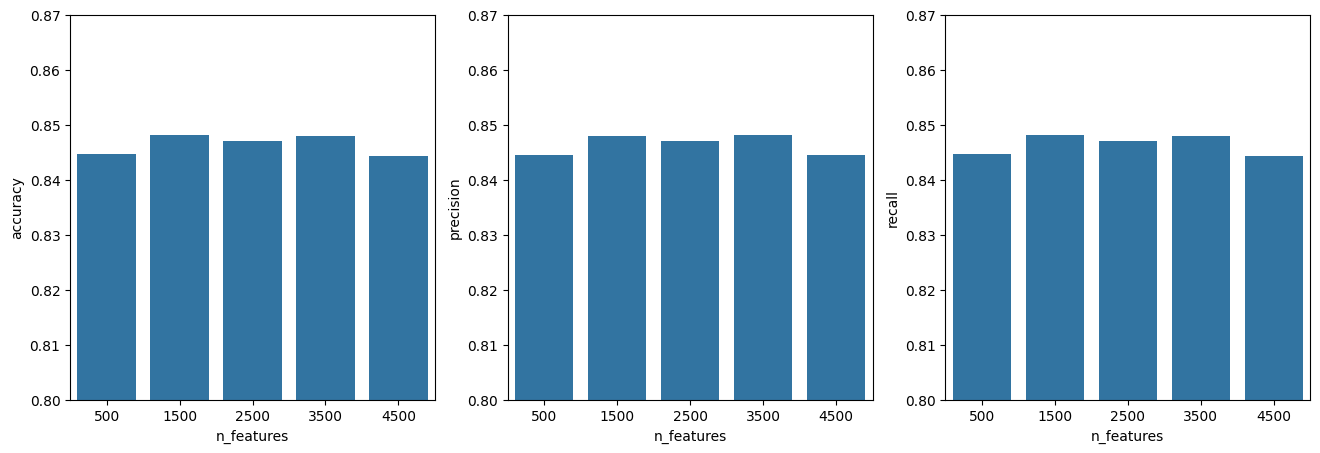

In [74]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
ax = sns.barplot(data=res, x='n_features', y="accuracy")
ax.set(ylim=(0.8, 0.87))

plt.subplot(1, 3, 2)
ax = sns.barplot(data=res, x='n_features', y="precision")
ax.set(ylim=(0.8, 0.87))

plt.subplot(1, 3, 3)
ax = sns.barplot(data=res, x='n_features', y="recall")
ax.set(ylim=(0.8, 0.87))

plt.show()

**Вывод:** Видно, что количество случайных признаков не сильно влияет на резльтат, если брать эту величину в разумных пределах. Наилучший скор получается при n_features = 1500.

#### Важно ли, какую модель обучать — логистическую регрессию или SVM?

Поскольку подобный эксперимент мы уже проводили выше, то напишу только вывод, а не буду дублировать код.

**Вывод:** и с логрегом, и с SVM модель показывает хорошее качество. Тем не менее, так как мы переформулировали именно задачу svm при выводе этого метода, то интуитивно хочется использовать его.


### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError